In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torchvision
import torchvision.transforms as transforms

from net import Classifier, ConvClassifier
from net.AutoEncoder import AutoEncoder, ConvAutoEncoder
from dataloader import CustomCifar
from dataloader import CustomDataset
from utils import cls_train


%matplotlib inline


In [2]:
ae_model_dir = 'stack_ae'
cls_model_dir = 'stack_classification'

ae_model_path = f'./ckpt/ae/{ae_model_dir}/model.pth'
cls_model_path = f'./ckpt/cls/{cls_model_dir}/model.pth'


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


/home/ubuntu-server/miniconda3/envs/torch/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def imshow(img):
  img = torchvision.utils.make_grid(img)
  npimg = img.detach().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


# AutoEncoder

### AutoEncoder training process

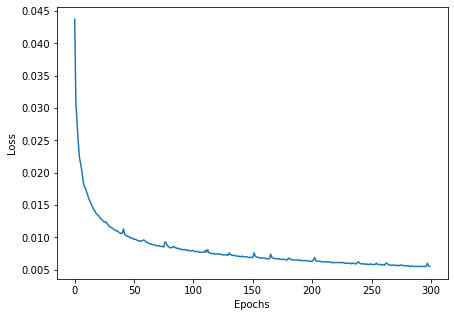

In [4]:
with open(f'./ckpt/ae/{ae_model_dir}/metrics.json') as f:
  losses = json.loads(f.read())

plt.rcParams["figure.figsize"] = (7, 5)

plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

plt.plot(losses['loss'])


### Classifier training process

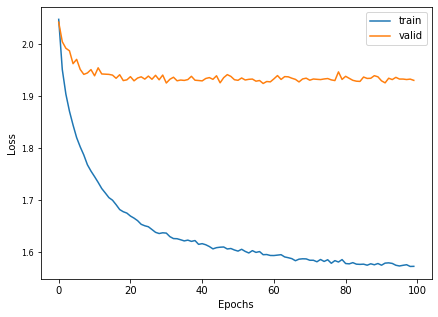

In [5]:
with open(f'./ckpt/cls/{cls_model_dir}/metrics.json') as f:
  losses = json.loads(f.read())

plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

# plt.xticks(range(0, 500000, 50000),fontsize=8)
plt.yticks(fontsize=8)

plt.plot(losses['train_loss'])
plt.plot(losses['valid_loss'])

plt.legend(['train','valid'])

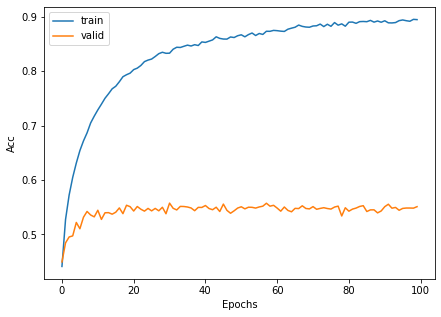

In [6]:
plt.xlabel('Epochs')
plt.ylabel('Acc')

plt.plot(losses['train_acc'])
plt.plot(losses['valid_acc'])

plt.legend(['train', 'valid'])


## Performance of AutoEncoder

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10 = CustomCifar()
cifar10.get_unbalanced_dataset(train_ratio=0.8)

trainset = CustomDataset(
    cifar10.train_data, cifar10.train_targets, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=24, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=2, drop_last=True)

# model = ConvAutoEncoder()
model = AutoEncoder()
model.load_state_dict(torch.load(ae_model_path))
model = model.eval()

iteration = iter(trainloader)


num_imgs_dict {6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}
train_data (34000, 32, 32, 3)
valid_data (8500, 32, 32, 3)
Files already downloaded and verified


torch.Size([24, 3, 32, 32])


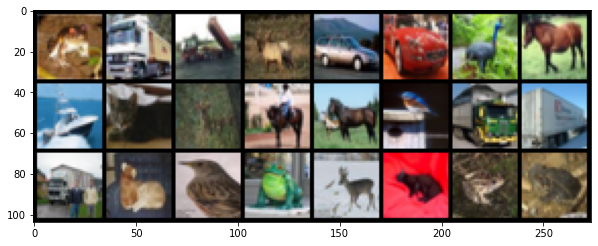

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


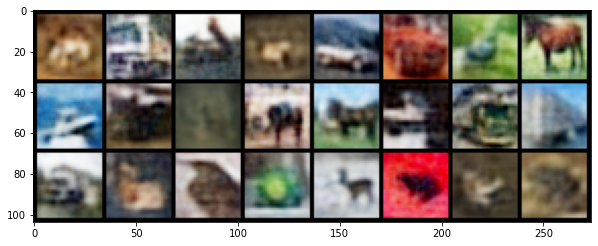

In [8]:
images, _ = next(iteration)

plt.rcParams["figure.figsize"] = (10, 10)

print(images.shape)
imshow(images)

embedding = model(images.float())
embedding = embedding.reshape(-1, 3, 32, 32)
imshow(embedding)


### Metrics Calculation

In [9]:
ae = AutoEncoder()
cls_net = Classifier()

ae.load_state_dict(torch.load(ae_model_path))
cls_net.load_state_dict(torch.load(cls_model_path))

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2, drop_last=False)
  


Files already downloaded and verified


In [10]:
# Iterate through test dataset
_, test_acc = cls_train(dataloader=testloader,
                                    ae_model=ae,
                                    cls_model=cls_net,
                                    mode='test')

print(f'Test Acc is {test_acc}')


Test Acc is 0.5293


### Confusion Matrix of predicted result

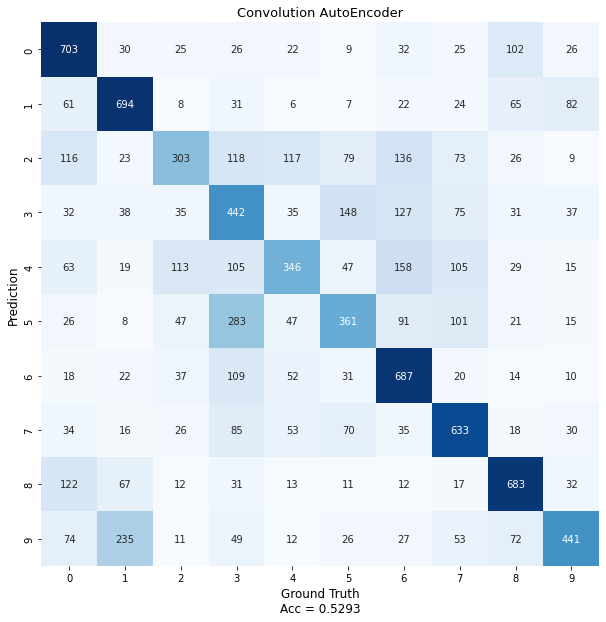

In [11]:
pred_class_list = []
gt_class_list = []
for img, label in testloader:
  img = img.float()
  # img.to('cuda:0')

  embedding = ae.encoder(img)
  pred_class = cls_net(embedding)

  pred_class = np.argmax(pred_class.detach().numpy(), axis=1)
  label = label.detach().numpy()

  pred_class_list.extend(pred_class)
  gt_class_list.extend(label)


conf_matrix = confusion_matrix(gt_class_list, pred_class_list)

plt.rcParams["figure.figsize"] = (10, 10)

ax = sns.heatmap(conf_matrix,
                 annot=True,
                 label=testset.classes,
                 fmt='d',
                 cmap='Blues',
                 cbar=False,
                 )

plt.xlabel(f'''Ground Truth\nAcc = {test_acc}''',
           fontsize=12)
plt.ylabel('Prediction', fontsize=12)
plt.title('Convolution AutoEncoder', fontsize=13)
plt.show()


# Conv AutoEncoder

In [12]:
conv_ae_model_dir = 'conv_ae'
conv_cls_model_dir = 'conv_classification'

conv_ae_model_path = f'./ckpt/ae/{conv_ae_model_dir}/model.pth'
conv_cls_model_path = f'./ckpt/cls/{conv_cls_model_dir}/model.pth'


### Convolutional AutoEncoder training process

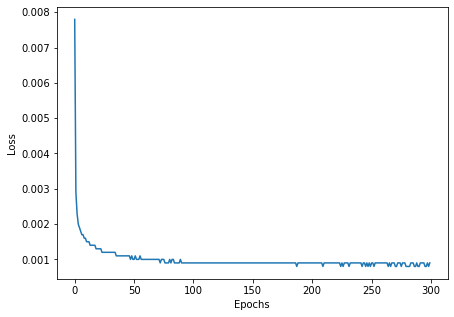

In [13]:
with open(f'./ckpt/ae/{conv_ae_model_dir}/metrics.json') as f:
  losses = json.loads(f.read())

plt.rcParams["figure.figsize"] = (7, 5)

plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

plt.plot(losses['loss'])


## Classifier training process

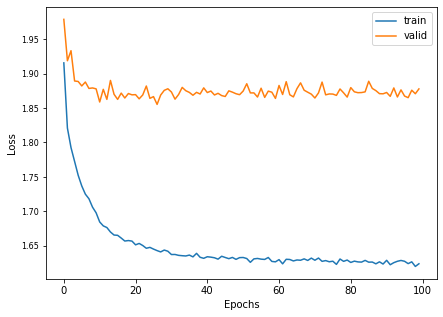

In [14]:
with open(f'./ckpt/cls/{conv_cls_model_dir}/metrics.json') as f:
  losses = json.loads(f.read())

plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

# plt.xticks(range(0, 500000, 50000),fontsize=8)
plt.yticks(fontsize=8)

plt.plot(losses['train_loss'])
plt.plot(losses['valid_loss'])

plt.legend(['train', 'valid'])


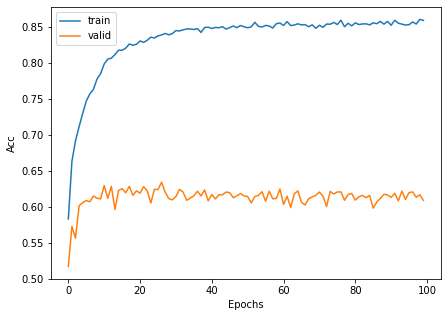

In [15]:
plt.xlabel('Epochs')
plt.ylabel('Acc')

plt.plot(losses['train_acc'])
plt.plot(losses['valid_acc'])

plt.legend(['train', 'valid'])


## Performance of Convolutional AutoEncoder

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar10 = CustomCifar()
cifar10.get_unbalanced_dataset(train_ratio=0.8)

trainset = CustomDataset(
    cifar10.train_data, cifar10.train_targets, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=24, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=2, drop_last=True)

model = ConvAutoEncoder()
model.load_state_dict(torch.load(conv_ae_model_path))
model = model.eval()

train_iteration = iter(trainloader)
test_iteration = iter(testloader)


num_imgs_dict {6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}
train_data (34000, 32, 32, 3)
valid_data (8500, 32, 32, 3)
Files already downloaded and verified


torch.Size([24, 3, 32, 32])


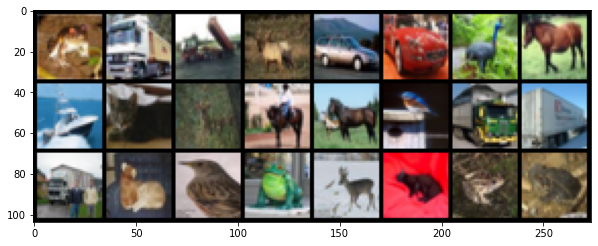

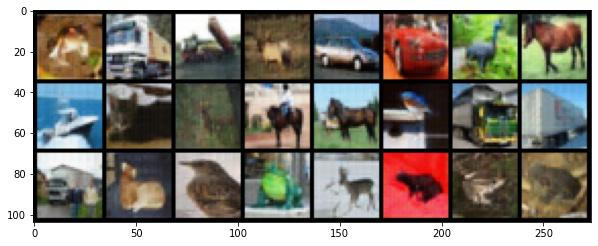

In [17]:
images, _ = next(train_iteration)

plt.rcParams["figure.figsize"] = (10, 10)

print(images.shape)
imshow(images)

embedding = model(images.float())
imshow(embedding)


torch.Size([1, 3, 32, 32])


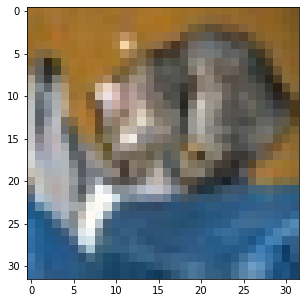

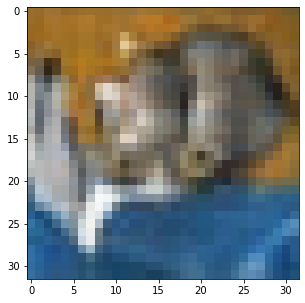

In [18]:
images, _ = next(test_iteration)

plt.rcParams["figure.figsize"] = (5, 5)

print(images.shape)
imshow(images)

embedding = model(images.float())
imshow(embedding)


In [19]:
ae = ConvAutoEncoder()
cls_net = ConvClassifier()

ae.load_state_dict(torch.load(conv_ae_model_path))
cls_net.load_state_dict(torch.load(conv_cls_model_path))

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2, drop_last=False)


Files already downloaded and verified


In [20]:
# Iterate through test dataset
_, test_acc = cls_train(dataloader=testloader,
                                    ae_model=ae,
                                    cls_model=cls_net,
                                    mode='test')

print(f'Test Acc is {test_acc}')


Test Acc is 0.6011


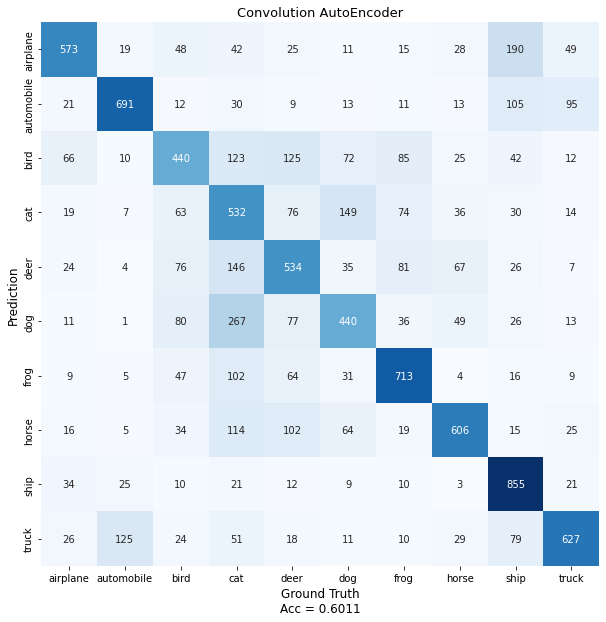

In [21]:
pred_class_list = []
gt_class_list = []
for img, label in testloader:
  img = img.float()
  # img.to('cuda:0')

  embedding = ae.encoder(img)
  pred_class = cls_net(embedding)

  pred_class = np.argmax(pred_class.detach().numpy(), axis=1)
  label = label.detach().numpy()

  pred_class_list.extend(pred_class)
  gt_class_list.extend(label)


class_dict = {idx: testset.classes[idx] for idx in range(10)}
conf_matrix = confusion_matrix(gt_class_list, pred_class_list)
conf_matrix = pd.DataFrame(conf_matrix).rename(columns=class_dict, index=class_dict)

plt.rcParams["figure.figsize"] = (10, 10)

ax = sns.heatmap(conf_matrix,
                 annot=True,
                 label=testset.classes,
                 fmt='d',
                 cmap='Blues',
                 cbar=False,
                 )

plt.xlabel(f'''Ground Truth\nAcc = {test_acc}''',
           fontsize=12)
plt.ylabel('Prediction', fontsize=12)
plt.title('Convolution AutoEncoder', fontsize=13)
plt.show()


## Convlolution AutoEncoder with Data Augmentation (DA)
- ### RandomHorizontalFlip and RandomCrop has been applied.

In [22]:
conv_ae_model_dir = 'conv_da_ae'
conv_cls_model_dir = 'conv_da_classification'

conv_ae_model_path = f'./ckpt/ae/{conv_ae_model_dir}/model.pth'
conv_cls_model_path = f'./ckpt/cls/{conv_cls_model_dir}/model.pth'


### Convolutional AutoEncoder + DA training process


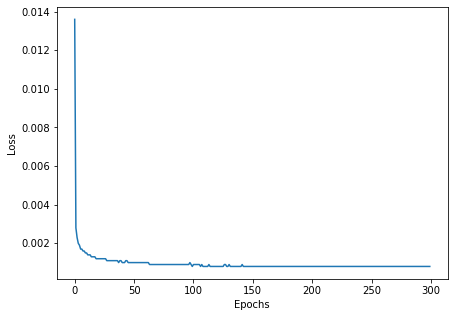

In [23]:
with open(f'./ckpt/ae/{conv_ae_model_dir}/metrics.json') as f:
  losses = json.loads(f.read())

plt.rcParams["figure.figsize"] = (7, 5)

plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

plt.plot(losses['loss'])


### Classifier training process


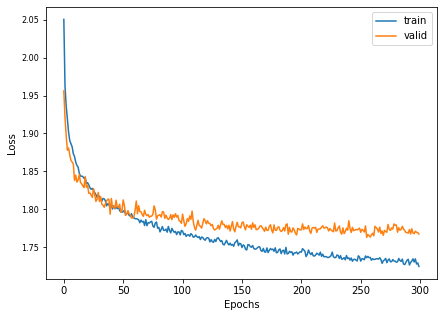

In [24]:
with open(f'./ckpt/cls/{conv_cls_model_dir}/metrics.json') as f:
  losses = json.loads(f.read())

plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

# plt.xticks(range(0, 500000, 50000),fontsize=8)
plt.yticks(fontsize=8)

plt.plot(losses['train_loss'])
plt.plot(losses['valid_loss'])

plt.legend(['train', 'valid'])


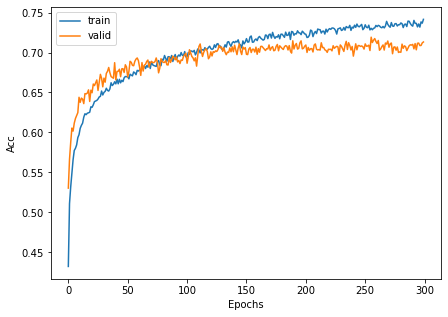

In [25]:
plt.xlabel('Epochs')
plt.ylabel('Acc')

plt.plot(losses['train_acc'])
plt.plot(losses['valid_acc'])

plt.legend(['train', 'valid'])


### Performance of Convolutional AutoEncoder trained with DA

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar10 = CustomCifar()
cifar10.get_unbalanced_dataset(train_ratio=0.8)

trainset = CustomDataset(
    cifar10.train_data, cifar10.train_targets, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=24, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=2, drop_last=True)

model = ConvAutoEncoder()
model.load_state_dict(torch.load(conv_ae_model_path))
model = model.eval()

train_iteration = iter(trainloader)
test_iteration = iter(testloader)


num_imgs_dict {6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}
train_data (34000, 32, 32, 3)
valid_data (8500, 32, 32, 3)
Files already downloaded and verified


torch.Size([24, 3, 32, 32])


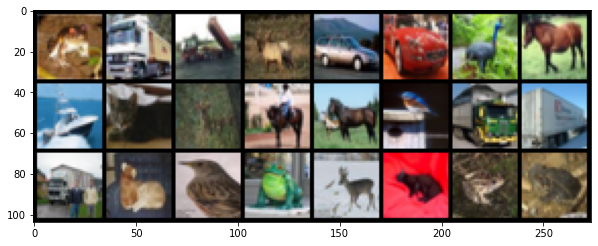

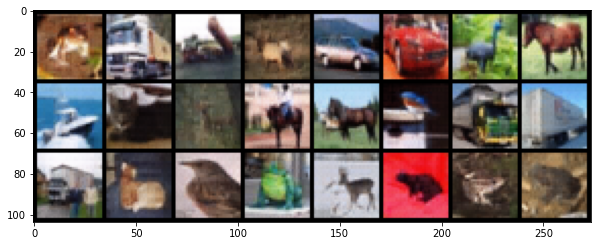

In [27]:
images, _ = next(train_iteration)

plt.rcParams["figure.figsize"] = (10, 10)

print(images.shape)
imshow(images)

embedding = model(images.float())
imshow(embedding)


input image


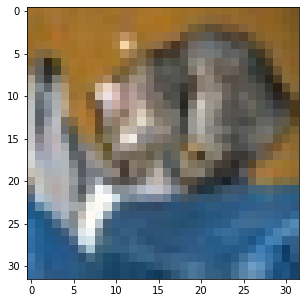

reconstructured image


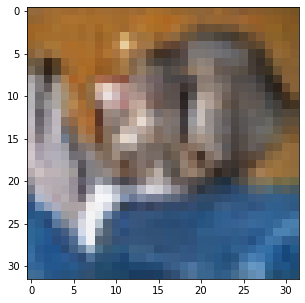

In [28]:
images, _ = next(test_iteration)

plt.rcParams["figure.figsize"] = (5, 5)

print('input image')
imshow(images)

print('reconstructured image')
embedding = model(images.float())
imshow(embedding)


In [29]:
ae = ConvAutoEncoder()
cls_net = ConvClassifier()

ae.load_state_dict(torch.load(conv_ae_model_path))
cls_net.load_state_dict(torch.load(conv_cls_model_path))

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2, drop_last=False)


Files already downloaded and verified


In [30]:
# Iterate through test dataset
_, test_acc = cls_train(dataloader=testloader,
                        ae_model=ae,
                        cls_model=cls_net,
                        mode='test')

print(f'Test Acc is {test_acc}')


Test Acc is 0.7134


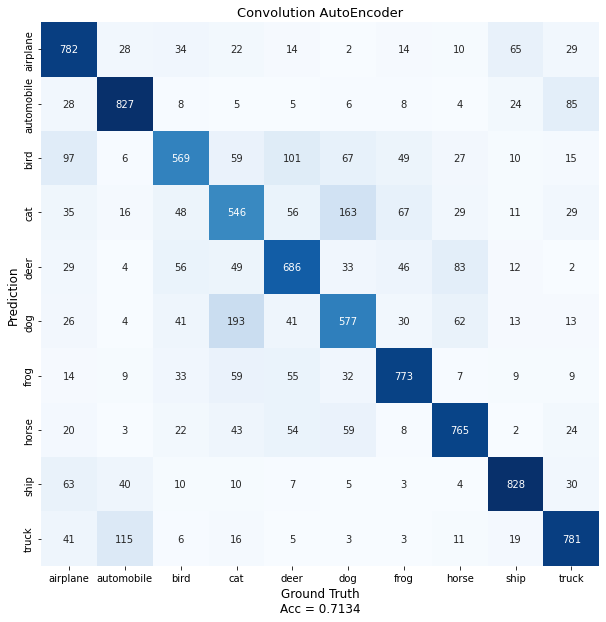

In [31]:
pred_class_list = []
gt_class_list = []
for img, label in testloader:
  img = img.float()

  embedding = ae.encoder(img)
  pred_class = cls_net(embedding)

  pred_class = np.argmax(pred_class.detach().numpy(), axis=1)
  label = label.detach().numpy()

  pred_class_list.extend(pred_class)
  gt_class_list.extend(label)


class_dict = {idx: testset.classes[idx] for idx in range(10)}
conf_matrix = confusion_matrix(gt_class_list, pred_class_list)
conf_matrix = pd.DataFrame(conf_matrix).rename(columns=class_dict, index=class_dict)

plt.rcParams["figure.figsize"] = (10, 10)

ax = sns.heatmap(conf_matrix,
                 annot=True,
                 label=testset.classes,
                 fmt='d',
                 cmap='Blues',
                 cbar=False,
                 )

plt.xlabel(f'''Ground Truth\nAcc = {test_acc}''',
           fontsize=12)
plt.ylabel('Prediction', fontsize=12)
plt.title('Convolution AutoEncoder', fontsize=13)
plt.show()


# Summary
- Typical stacking autoencoder had difficulty in extracting the detailed feature which led to failing of clear reconsturcture.
- Convolutional autoencoder enabled detailed feature extraction making it possible to reconsturcture the image much clearer than the Typical autoencoder.
- Data augmentaiton has led to much more detailed, distinctive feature extraction.

Since all the classification network has similar architecture, the autoencoder part is the major difference.
(Of course, the input of the classifier is different according to the embedding of the hidden layer of respective autoencoder. 
Though number of the FC layer are the same.)

There are 